# Exploring Energy Consumption Between Croatia and Slovenia Since 1991

## Introduction

The following data comes from an Energy repository from Our World in Data, which includes a wide range of indicators related to energy consuption, various energy sources, economic indicators, and electricity generation. The final datasets describes energy profiles of Slovenia and Coratia, with rows representing each country from the years 1991 to 2022, and columns that describ demographic information, energy production, energy consuption, per capita metrics, electricity demand and so forth. 

By implementing unsupervised techniques like PCA/SVD Analysis, KMeans clustering, and Hierarchical Clustering, the objective is to find patterns, structures, or groupings among the data. Projecting high-dimensional energy data into 2D/3D space using dimensionality reduction, like PCA/SVD Analysis, might help visualize trajectories of energy evolution and compare the two countries across time periods. Clustering techniques like KMeans might help group years based on similar energy consumption patterns to discover historical trends or energy shifts.

## Theoretical Background

Unsupervised learning are machine learnig algorithms that are able to learn from unlabled data, with a goal of understanding the structure of the data or exploring the data further. These types of models may be useful when you dont know the goal initially or you want to learn more about how the data can be grouped into clusters. Some examples of unsupervised learning include prinical component analysis (PCA), Singular Value Decomposition (SVD), Matrix Completion, KMeans clustering, and Hierarchical Clustering.

Principal Component Analysis (PCA) is a dimensionality reduction technique that is widely used to detect unseen trends and patterns by projecting the data into a lower dimensional space while retaining most of the varaince. PCA transforms a dataset with correlated variables into a new coordinate system by identifying orthogonal axes (principal components) where the data variance is maximized. The first principal component accounts for the largest possible variance of the data, and the second component accounts for the next largest variance, and so forth. 

Singular Value Decomposition (SVD) is a similar technique to PCA, with scaled data, also simialrly used as a dimensionality reduction technique. Given a data matrix (X) of size nxp, it can be decomposed as X=UEV^T. Where U is an nxn matrix that describes the location of each data point in singular vector space, where each column represents a principal component. E is an nxp diagonal matrix of singular values that represent their importance or proportion of variance explained. V^T is the transpose of a pxp orthogonal matrix that shows the direction of variance int he data. 

KMeans is an unsupervised learning technique that groups data points by minimizing the varaince between the data points and cluster centroids. The algorithm seeks to minimize within-cluster variation using eucledian distance. The first step randomly assigns data points into a cluster. Then the center of each cluster is computed and data points are reassiged to observations closest to the cluster centroid, this is repeated until the algorithm converges. KMeans are a good model to use for specifically numerical data that makes sense when distance is a reasonable metric and points all close to their means. A KMeans model is sensitive to its initialization and the selection of the number of clusters (k). Using a Silhouette score to measure how similar a point is to its own cluster versus other clusters can help choose k.

Hierarchical Clustering is an unsupervised learning method that is used to group similar data points together and organize the data into a tree-like structure called a dendrogram. The linkage of the tree is a measure of the distance between clusters before they are merged or divided. Different types of linkages will be explored to analyze the data including complete linkage, average linkage, and single linkage. Complete linkage calculates distance between clusterns by using maximum pariwise dissimilarity, or identifying the most dissimilar group. Complete linkage is useful when distance is meaningful, and it is expected for the data to have clearly seperated groups. Single linkage is calculated by finding the shortest distance between any single point among two clusters, which find the minimal intercluster dissimilarity. This method is useful in finding chain-like clusters where we might expect the data to be connected by a series of close points or irregular groupings, however this can also lead to clusters getting merged through a single data point and sensitivity to outliers.

## Methodology

The original data comes from and Energy Dataset from 'Our World in Data', which contains annual energy data for various countries worldwide spanning a wide range of 130 columns and over 21,000 rows. This study will focus on analyzing annual energy data specifically from Croatia and Slovenia from 1991 to 2022, including infromation on their demographics, energy production, energy consumption, and energy demands. Since the dataset is sparse, with many columns having over 75% missing values, the study will focus on the countries with the least amount of missing values being Slovenia (4.95% missing values) and Croatia (7.08%). To address missing values within these countries, columns with multiple missing values (10+) were dropped and smaller missing values were examined by row and dropped or imputed accordingly. The final data sets results in Croatia and Slovenia energy profiles with scaled numerical values that are sufficent to perform unsupervised learning techniques and discover unseen patterns among the data.

The PCA model will be implemented on the two datasets, Croatia and Slovenia, respectively each over the span of 32 years (rows) and 12 energy related varaibles. The data is standardized using StandardScalar to ensure all features equally contribute to the PCA regardless of their original scale. PCA is applied to both data sets using 12 components, which is the same as the number of features. The explained varaince ratio and cumulative explained variance is computed and ploted for both countries. 

The KMeans model will be implemented by analyzing both Croatia and Slovenia across various cluster sizes from 2 to 14. The optimal model size (k) will be chosen by analyzing the silhouette score and intertia. A lower within cluster variation (intertia) is ideal but the elbow method will be used to acknowledge diminishing returns. A higher Silhouette score will refelct how well seperated and cohesive the clusters are. This model will group different years to see energy related trends among the countries.

Hierarchical Clustering will be implemented using four different linkage methods including: complete, single, average, and ward. The input data was transposed so each energy source is treated as an observation, where rows are the energy types and columns are the years. Dendrograms will be used to visualize the clustering structure. Finally, silhouette analysis will be used to evaluate the optimal number of clusters.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, fcluster
from scipy.spatial.distance import pdist
from ISLP.cluster import compute_linkage

In [4]:
np.random.seed(3799)

### Data Cleaning and Exploration

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/energy-data/master/owid-energy-data.csv')

In [6]:
# Check the amount of rows and features
df.shape

(21812, 130)

In [7]:
# Check how many nans there are in the columns
pd.set_option('display.max_rows', None)
df.isna().sum()[df.isna().sum() > 0]

iso_code                                         5000
population                                       3365
gdp                                             10037
biofuel_cons_change_pct                         20006
biofuel_cons_change_twh                         19016
biofuel_cons_per_capita                         19412
biofuel_consumption                             18936
biofuel_elec_per_capita                         16242
biofuel_electricity                             15978
biofuel_share_elec                              16001
biofuel_share_energy                            19034
carbon_intensity_elec                           15977
coal_cons_change_pct                            16516
coal_cons_change_twh                            16398
coal_cons_per_capita                            17060
coal_consumption                                16293
coal_elec_per_capita                            15718
coal_electricity                                15103
coal_prod_change_pct        

There are an overwhelmingly large amount of NaNs in this dataset. I need a way to focus on the data that showcases a complete view of the data, i.e., something that has a lot of data present. I will attempt to solve this by calculating the percentages of NaNs by each country to determine if there are any countries containing a low amount of NaNs. I want this because imputing or utilizing methods to fill in NaNs to select my desired countries could result in an unrepresentative dataset, so it is best to work with the countries that are most complete.

In [8]:
# reset the display to not show all rows
pd.reset_option('display.max_rows')

In [9]:
# calculate the percentage of NaNs present in each row
df_copy = df.copy()
df_copy['nan_percent'] = df_copy.isna().mean(axis=1) * 100

# group by country and derive the mean of the NaN percentage to find the country with the lowest amount of NaNs
mean_nan_percent_by_country = df_copy.groupby('country')['nan_percent'].mean()

# selecting for countries that have their data with less than 10% of NaNs
print(mean_nan_percent_by_country[mean_nan_percent_by_country < 10])

country
Croatia     7.081448
Slovenia    4.954751
Name: nan_percent, dtype: float64


The criteria of less than 10% of NaNs shows that there are only two countries present that are able to be worked with. We will use these specific countries for our purposes. Now, we will clean the rest of the NaNs in these countries since utilizing particular unsupervised learning methods requires no NaNs to be present.

In [10]:
croatia = df[df['country'] == 'Croatia']

In [11]:
# determine the columns containing NaNs
croatia_nans = croatia.isna().sum()[croatia.isna().sum() > 0]
croatia_nans

gdp                                  1
biofuel_cons_change_pct             19
biofuel_cons_change_twh             18
biofuel_cons_per_capita             17
biofuel_consumption                 17
biofuel_share_energy                17
coal_cons_change_pct                 1
coal_cons_change_twh                 1
coal_prod_change_pct                26
coal_prod_change_twh                10
coal_prod_per_capita                 9
coal_production                      9
energy_cons_change_pct               1
energy_cons_change_twh               1
energy_per_gdp                       1
fossil_cons_change_pct               1
fossil_cons_change_twh               1
gas_cons_change_pct                  1
gas_cons_change_twh                  1
gas_prod_change_pct                 10
gas_prod_change_twh                 10
gas_prod_per_capita                  9
gas_production                       9
hydro_cons_change_pct                1
hydro_cons_change_twh                1
low_carbon_cons_change_pc

In [12]:
# Check for rows because we require columns with NaNs that aren't a large proportion of the rows
croatia.shape

(34, 130)

In [13]:
# remove the columns that contain more than one NaN
croatia_no_nans = croatia.loc[:, croatia.isna().sum() <= 1].copy()

In [14]:
# need to find out where the remainder of the NaNs are to determine how they should be removed or imputed
remainder = croatia_no_nans.isna().sum()[croatia_no_nans.isna().sum() > 0]
croatia_nan_idxs = {col: croatia_no_nans.index[croatia_no_nans[col].isna()].tolist() for col in remainder.index}
croatia_nan_idxs

{'gdp': [5040],
 'coal_cons_change_pct': [5007],
 'coal_cons_change_twh': [5007],
 'energy_cons_change_pct': [5007],
 'energy_cons_change_twh': [5007],
 'energy_per_gdp': [5040],
 'fossil_cons_change_pct': [5007],
 'fossil_cons_change_twh': [5007],
 'gas_cons_change_pct': [5007],
 'gas_cons_change_twh': [5007],
 'hydro_cons_change_pct': [5007],
 'hydro_cons_change_twh': [5007],
 'low_carbon_cons_change_pct': [5007],
 'low_carbon_cons_change_twh': [5007],
 'nuclear_cons_change_twh': [5007],
 'oil_cons_change_pct': [5007],
 'oil_cons_change_twh': [5007],
 'other_renewables_cons_change_twh': [5007],
 'renewables_cons_change_pct': [5007],
 'renewables_cons_change_twh': [5007],
 'solar_cons_change_twh': [5007],
 'wind_cons_change_twh': [5007]}

Clearly, the 5007th index is empty, so we can be confident to drop that. Also, the 5040th index has a couple of missing value, which we will drop too.

In [15]:
# drop the 5040th and 5007th indices
croatia_no_nans.drop([5040, 5007], inplace=True)

In [16]:
# double check that there are no more NaNs
croatia_no_nans.isna().sum()[croatia_no_nans.isna().sum() > 0]

Series([], dtype: int64)

In [17]:
# Set up slovenia to be cleaned
slovenia = df[df['country'] == 'Croatia']

In [18]:
# determine the columns containing NaNs
slovenia_nans = slovenia.isna().sum()[slovenia.isna().sum() > 0]
slovenia_nans

gdp                                  1
biofuel_cons_change_pct             19
biofuel_cons_change_twh             18
biofuel_cons_per_capita             17
biofuel_consumption                 17
biofuel_share_energy                17
coal_cons_change_pct                 1
coal_cons_change_twh                 1
coal_prod_change_pct                26
coal_prod_change_twh                10
coal_prod_per_capita                 9
coal_production                      9
energy_cons_change_pct               1
energy_cons_change_twh               1
energy_per_gdp                       1
fossil_cons_change_pct               1
fossil_cons_change_twh               1
gas_cons_change_pct                  1
gas_cons_change_twh                  1
gas_prod_change_pct                 10
gas_prod_change_twh                 10
gas_prod_per_capita                  9
gas_production                       9
hydro_cons_change_pct                1
hydro_cons_change_twh                1
low_carbon_cons_change_pc

In [19]:
# Check for rows because we require columns with NaNs that aren't a large proportion of the rows
slovenia.shape

(34, 130)

In [20]:
# remove the columns that contain more than one NaN
slovenia_no_nans = slovenia.loc[:, slovenia.isna().sum() <= 1].copy()

In [21]:
# need to find out where the remainder of the NaNs are to determine how they should be removed or imputed
remainder_slov = slovenia_no_nans.isna().sum()[slovenia_no_nans.isna().sum() > 0]
slovenia_nan_idxs = {col: slovenia_no_nans.index[slovenia_no_nans[col].isna()].tolist() for col in remainder_slov.index}
slovenia_nan_idxs

{'gdp': [5040],
 'coal_cons_change_pct': [5007],
 'coal_cons_change_twh': [5007],
 'energy_cons_change_pct': [5007],
 'energy_cons_change_twh': [5007],
 'energy_per_gdp': [5040],
 'fossil_cons_change_pct': [5007],
 'fossil_cons_change_twh': [5007],
 'gas_cons_change_pct': [5007],
 'gas_cons_change_twh': [5007],
 'hydro_cons_change_pct': [5007],
 'hydro_cons_change_twh': [5007],
 'low_carbon_cons_change_pct': [5007],
 'low_carbon_cons_change_twh': [5007],
 'nuclear_cons_change_twh': [5007],
 'oil_cons_change_pct': [5007],
 'oil_cons_change_twh': [5007],
 'other_renewables_cons_change_twh': [5007],
 'renewables_cons_change_pct': [5007],
 'renewables_cons_change_twh': [5007],
 'solar_cons_change_twh': [5007],
 'wind_cons_change_twh': [5007]}

Luckily, the Slovenia data is showing the same missed values that Croatia has, which helps us for comparison their countries for our models.

In [22]:
# drop the 5040th and 5007th indices
slovenia_no_nans.drop([5040, 5007], inplace=True)

In [23]:
# double check that there are no more NaNs
slovenia_no_nans.isna().sum()[slovenia_no_nans.isna().sum() > 0]

Series([], dtype: int64)

In [24]:
# assign the variables back to workable names for efficiency
slovenia_df = slovenia_no_nans
croatia_df = croatia_no_nans

In [25]:
# isolate the numerical variables 
croatia_df_numeric = croatia_df.drop(['year', 'country', 'iso_code'], axis =1).copy()
slovenia_df_numeric = slovenia_df.drop(['year', 'country', 'iso_code'], axis =1).copy()

We want to determine the primary means of energy consumption for Slovenia and Croatia. Therefore, we will isolate only the columns that are associated with types of energy consumption.

In [26]:
# isolate the consumption columns
consumption_columns_croatia = [col for col in croatia_df_numeric.columns if 'consumption' in col]
consumption_columns_slovenia = [col for col in slovenia_df_numeric.columns if 'consumption' in col]

In [27]:
# select only the consumption columns in the dataframe
croatia_consumption = croatia_df_numeric[consumption_columns_croatia]
slovenia_consumption = slovenia_df_numeric[consumption_columns_slovenia]

In [28]:
# gather the years for each country to use as indices
years_croatia = croatia_df['year']
years_slovenia = slovenia_df['year']

In [29]:
# scale the data for preparation to be used in the models
croatia_scaled = StandardScaler().fit_transform(croatia_consumption)
slovenia_scaled = StandardScaler().fit_transform(slovenia_consumption)

In [30]:
# put the scaled data back into a dataframe, using the years as indices
croatia_dfscaled = pd.DataFrame(croatia_scaled, columns=croatia_consumption.columns, index=years_croatia.values)
slovenia_dfscaled = pd.DataFrame(slovenia_scaled, columns=slovenia_consumption.columns, index=years_slovenia.values)

In [31]:
slovenia_dfscaled

,coal_consumption,fossil_fuel_consumption,gas_consumption,hydro_consumption,low_carbon_consumption,nuclear_consumption,oil_consumption,other_renewable_consumption,primary_energy_consumption,renewables_consumption,solar_consumption,wind_consumption
1991,-0.153238,-1.175144,-1.445166,-0.456225,-0.828351,0.0,-0.944475,-0.556000,-1.622952,-0.828351,-0.575527,-0.662453
1992,-0.461822,-1.147823,-1.048143,-1.461134,-1.633873,0.0,-0.944475,-0.567048,-2.022605,-1.633873,-0.575527,-0.662453
1993,-0.797890,-0.802002,-0.419524,-1.289508,-1.487351,0.0,-0.613496,-0.531353,-1.596528,-1.487351,-0.575527,-0.662453
1994,-1.510528,-1.010733,-1.122125,-0.533370,-0.892959,0.0,-0.417765,-0.567048,-1.491691,-0.892959,-0.575527,-0.662453
1995,-1.722680,-0.738254,-1.969474,-0.321582,-0.721517,0.0,0.270179,-0.558549,-1.126290,-0.721517,-0.575527,-0.662453
1996,-1.900116,-0.744932,-0.723265,1.540880,0.765849,0.0,-0.094232,-0.558549,-0.344475,0.765849,-0.575527,-0.662453
1997,-1.338396,-0.127482,-0.299131,-0.175960,-0.610992,0.0,0.361206,-0.580646,-0.452371,-0.610992,-0.575527,-0.662453
1998,-1.398184,0.461433,-0.764162,-0.032361,-0.490544,0.0,1.271019,-0.558549,0.204789,-0.490544,-0.575527,-0.662453
1999,-1.545726,0.403392,-0.603791,1.083210,0.400353,0.0,1.191694,-0.558549,0.618633,0.400353,-0.575527,-0.662453
2000,-0.281493,0.044700,-0.499021,0.336318,-0.202116,0.0,0.309690,-0.580646,-0.062014,-0.202116,-0.575527,-0.662453


### Principal Component Analysis (PCA)

In [32]:
croatia_dfscaled.shape, slovenia_dfscaled.shape

((32, 12), (32, 12))

In [33]:
# perform PCA with 12 components (the same as the number of columns) for slovenia
pca_croatia = PCA(n_components=12)
X_pca_croatia = pca_croatia.fit_transform(croatia_dfscaled)

In [34]:
# perform PCA with 12 components (the same as the number of columns) for croatia
pca_slovenia = PCA(n_components=12)
X_pca_slovenia = pca_slovenia.fit_transform(slovenia_dfscaled)

In [35]:
# get the proportion of variance of each component
explained_var_croatia = pca_croatia.explained_variance_ratio_

# get the cumulative proportion of variance
cum_explained_var_croatia = np.cumsum(explained_var_croatia)

In [36]:
# slovenia
explained_var_slovenia = pca_slovenia.explained_variance_ratio_
cum_explained_var_slovenia = np.cumsum(explained_var_slovenia)

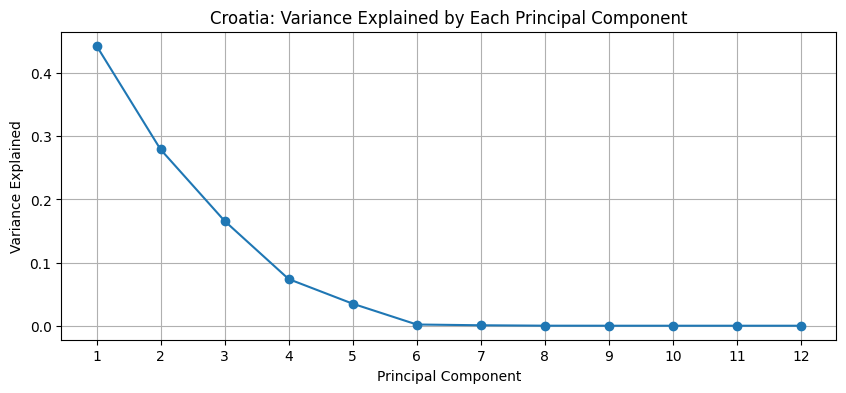

In [37]:
# plot the variance explained by each principal component
plt.figure(figsize=(10,4))
plt.plot(range(1, 13), explained_var_croatia, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Croatia: Variance Explained by Each Principal Component')
plt.xticks(range(1, 13))
plt.grid()
plt.show()

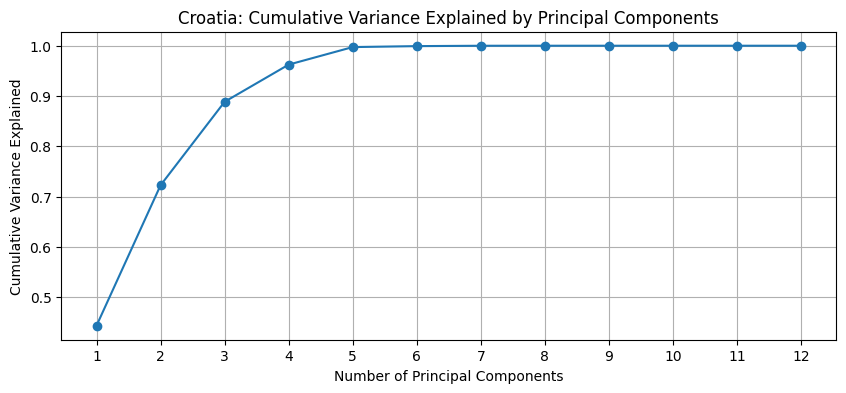

In [38]:
# plot the cumulative proportional variance 
plt.figure(figsize=(10,4))
plt.plot(range(1, 13), cum_explained_var_croatia, 'o-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Croatia: Cumulative Variance Explained by Principal Components')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

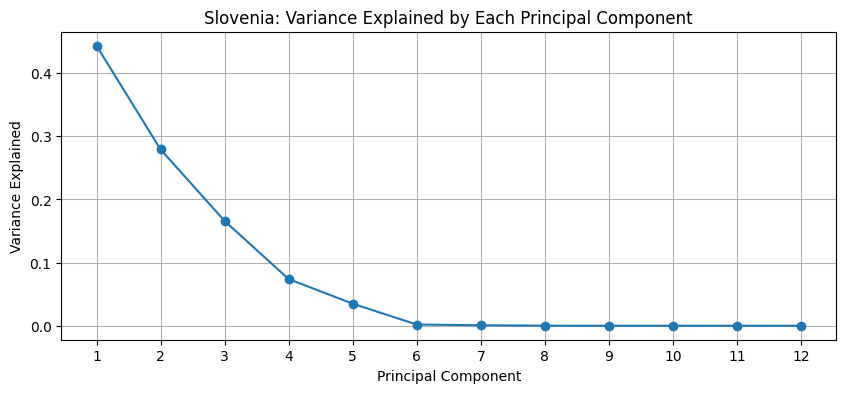

In [39]:
# slovenia
# plot the variance explained by each principal component
plt.figure(figsize=(10,4))
plt.plot(range(1, 13), explained_var_slovenia, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Slovenia: Variance Explained by Each Principal Component')
plt.xticks(range(1, 13))
plt.grid()
plt.show()

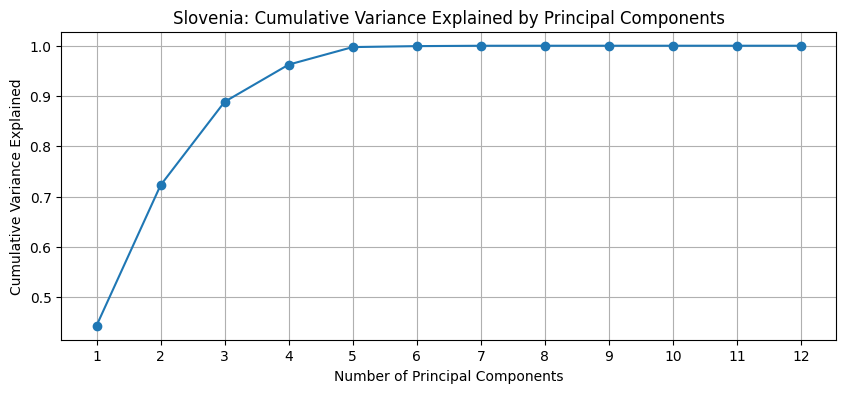

In [40]:
# plot the cumulative proportional variance 
plt.figure(figsize=(10,4))
plt.plot(range(1, 13), cum_explained_var_slovenia, 'o-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Slovenia: Cumulative Variance Explained by Principal Components')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

### Discuss what the shape of it means about the decomposition:
For both Croatia and Slovenia, the graphs are similar if not the same. It is only the first 5 principal components that contain all of the variance of the data, with the first PC explaining almost half (~46%) of the total variance in explaining the energy consumption for the countries. Let's look closer to determine the weights of the first principal component to determine what features are contributing to this outcome.

In [41]:
# check the weights of each of the features to see what they contribute to with the first PC
loadings = pd.DataFrame(
    pca_croatia.components_.T,
    index=croatia_dfscaled.columns,
    columns=[f'PC{i+1}' for i in range(pca_croatia.n_components_)]
)

print(loadings['PC1']) 

coal_consumption              -1.228719e-01
fossil_fuel_consumption       -3.453921e-01
gas_consumption               -9.985630e-02
hydro_consumption              1.743655e-02
low_carbon_consumption         3.177737e-01
nuclear_consumption            3.469447e-18
oil_consumption               -3.605139e-01
other_renewable_consumption    3.978541e-01
primary_energy_consumption    -1.794979e-01
renewables_consumption         3.177737e-01
solar_consumption              4.035527e-01
wind_consumption               4.123576e-01
Name: PC1, dtype: float64


The first principal component represents a clear difference between renewable/low-carbon energy sources and fossil fuel consumption. Years with higher wind, solar, and other renewable energy use score highly on this component, while years with greater fossil fuel (especially oil and gas) consumption score lower. To figure out how this is changing over time, we can plot the years with the principal components and see how high or low they are.

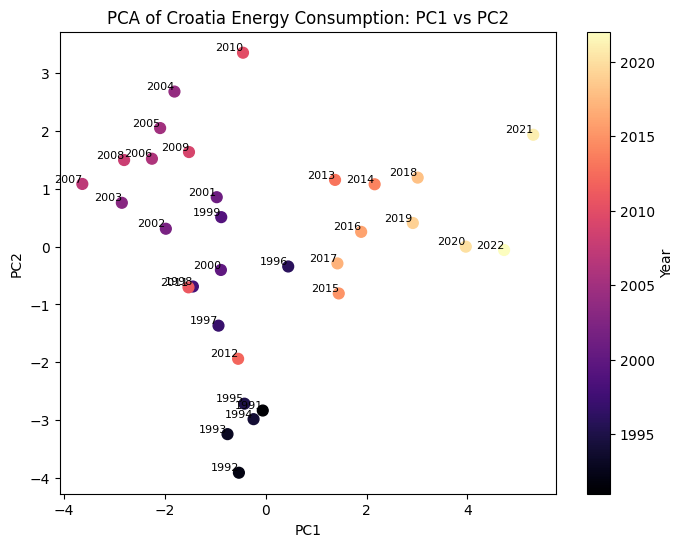

In [46]:
# get the year values to project onto PCA space
years_croatia = croatia_dfscaled.index.values

# Plot PC1 vs PC2 (color by year)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_croatia[:,0], X_pca_croatia[:,1], cmap='magma', c=years_croatia, s=60)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Croatia Energy Consumption: PC1 vs PC2')
plt.colorbar(scatter, label='Year')
for i, year in enumerate(years_croatia):
    plt.text(X_pca_croatia[i,0], X_pca_croatia[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.show()

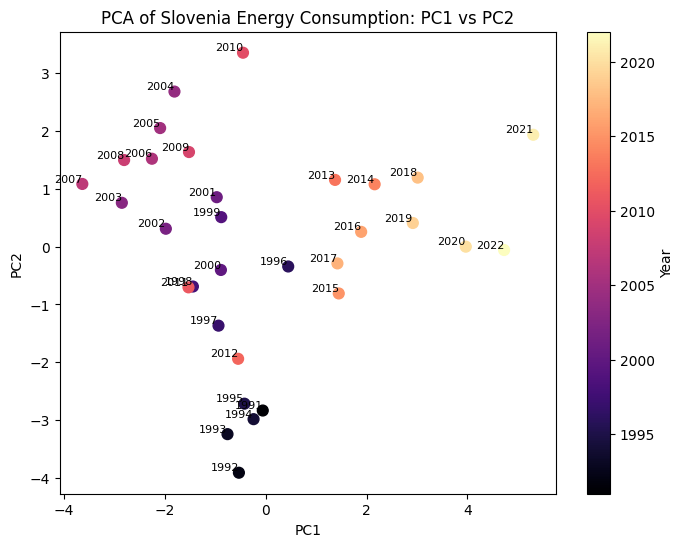

In [48]:
# get the year values to project onto PCA space
years_slovenia = slovenia_dfscaled.index.values

# Plot PC1 vs PC2 (color by year)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_slovenia[:,0], X_pca_slovenia[:,1], cmap='magma', c=years_slovenia, s=60)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Slovenia Energy Consumption: PC1 vs PC2')
plt.colorbar(scatter, label='Year')
for i, year in enumerate(years_slovenia):
    plt.text(X_pca_slovenia[i,0], X_pca_slovenia[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.show()

From these graphs, since the earlier years show low PC1 values and the later years show higher PC1 values, we can reasonably conclude that the main trend in Croatia’s (and Slovenia’s) energy consumption has been a shift from fossil fuels toward renewables over time.

### Compare Slovenia's two features against the first two principal components

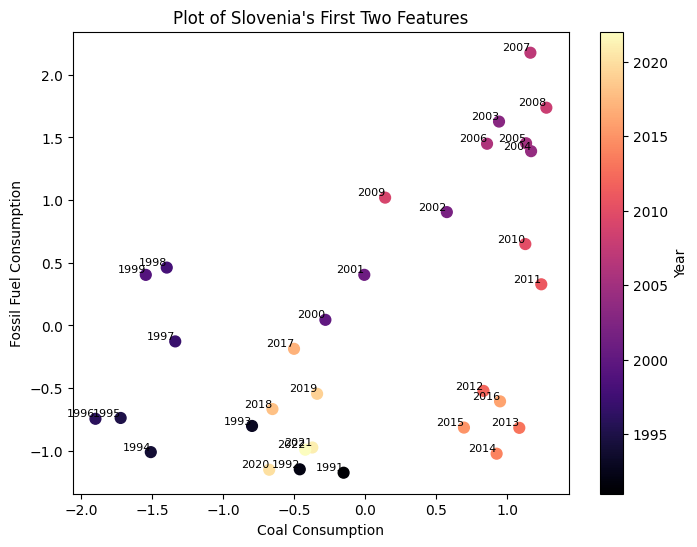

In [50]:
# plot the original two features to compare against PC1/PC2 of the slovenia df
plt.figure(figsize=(8,6))
scatter = plt.scatter(slovenia_dfscaled.iloc[:,0], slovenia_dfscaled.iloc[:,1], cmap='magma', c=years_slovenia, s=60)
plt.xlabel('Coal Consumption')
plt.ylabel('Fossil Fuel Consumption')
plt.title("Plot of Slovenia's First Two Features")
plt.colorbar(scatter, label='Year')
for i, year in enumerate(years_slovenia):
    plt.text(slovenia_dfscaled.iloc[i,0], slovenia_dfscaled.iloc[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.show()

For Slovenia's first two principal components, there is a progression over the years, with early years (darker colors, e.g., 1992–1995) clustered at the top, and later years (lighter, e.g., 2020–2022) drifting towards the bottom right. As spoken about earlier when comparing against the first principal component analysis, it was concluded that the first principal component corresponds to there being a shift from fossil fuels toward renewables over time.

For Sloevnia's first two features, there are trends over the years of which type of energy consumption is used. For instance, in the earlier 1990s, there was little coal and fossil fuel consumption (but coal > fossil fuel by a little, e.g., 1991, 1992, and 1993). As the years went into the 2000s, there is a gradual shift in both coal and fossil fuel consumption, but then into the 2010s the fossil fuels dropped while coal consumption stayed very high. Finally, from 2017 onwards, coal consumption began to drift down while fossil fuels still stayed low. 

### How can the U and V* matrix from the SVD (or "x" and "rotation" from PCA) be interpreted?

In [51]:
# peform the decomposition
U, S, Vt = np.linalg.svd(croatia_dfscaled, full_matrices=False)

In [52]:
# inspect the shape of each
U.shape, S.shape, Vt.shape

((32, 12), (12,), (12, 12))

In [53]:
# view one of each item
U[:1], S[:1], Vt[:1]

(array([[ 0.00481905, -0.2857803 ,  0.10067351, -0.18542665, -0.10201403,
          0.14062198,  0.28784931, -0.09846067,  0.07955792, -0.21283215,
         -0.19584213,  0.25308787]]),
 array([12.4932359]),
 array([[ 1.22871923e-01,  3.45392083e-01,  9.98562950e-02,
         -1.74365478e-02, -3.17773732e-01, -3.46944695e-18,
          3.60513853e-01, -3.97854119e-01,  1.79497903e-01,
         -3.17773732e-01, -4.03552698e-01, -4.12357589e-01]]))

Each row of **U** can be interpreted as one observation (in our case, each year) that has 12 scores, each one representing the principal component it is associated with (e.g., the first index in the row represents the first principal component). All these observations indicate how each load onto each principal component. For example, taking the first column of U (PC1), it shows us how all the years are being loaded/projected onto the first principal component.

Each row of **Vt** can be interpreted as how each feature is weighted on each principal component. So the larger the value (in magnitude), the more that feature influences the corresponding principal component, and positive and negative values show whether the feature contributes in the same direction as the component or in the opposite direction. Therefore, if one looks at the first row of Vt, it can be seen which features are most responsible for the variation captured by the first principal component.

## K-Means Clustering

In [54]:
# Find optimal cluster amount using silhouette score vs inertia
inertia_ct = []
inertia_sv = []
silh_ct = []
silh_sv = []

for k in range(2, 15):
    kmeans_ct = KMeans(n_clusters=k).fit(croatia_dfscaled)
    kmeans_sv = KMeans(n_clusters=k).fit(slovenia_dfscaled)
    inertia_ct.append(kmeans_ct.inertia_)
    inertia_sv.append(kmeans_sv.inertia_)
    silh_ct.append(silhouette_score(croatia_dfscaled, kmeans_ct.labels_))
    silh_sv.append(silhouette_score(slovenia_dfscaled, kmeans_sv.labels_))

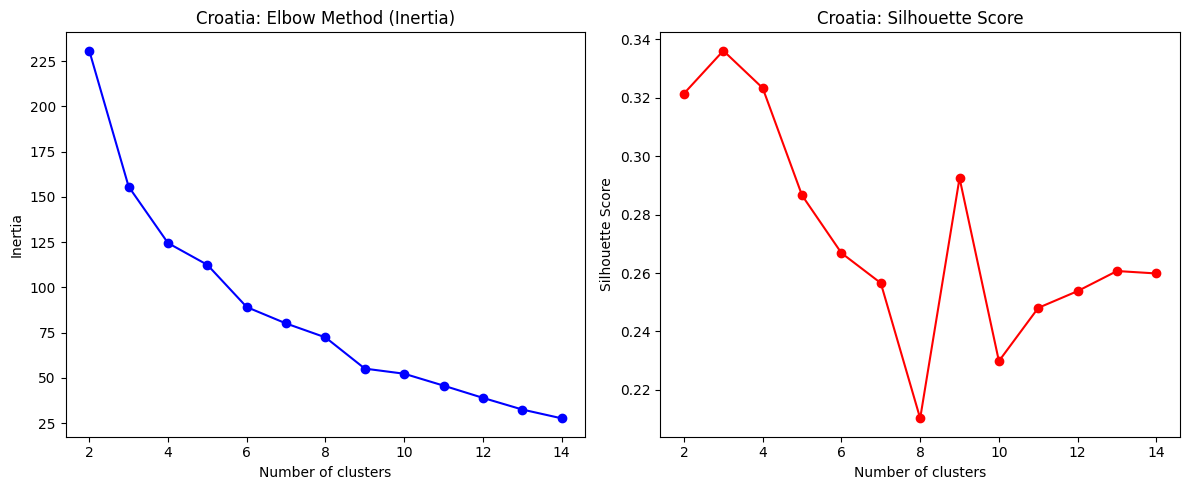

In [55]:
K = range(2, 15)

# plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# elbow plot
ax1.plot(K, inertia_ct, 'bo-')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Croatia: Elbow Method (Inertia)')

# silhouette plot
ax2.plot(K, silh_ct, 'ro-')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Croatia: Silhouette Score')

plt.tight_layout()
plt.show()

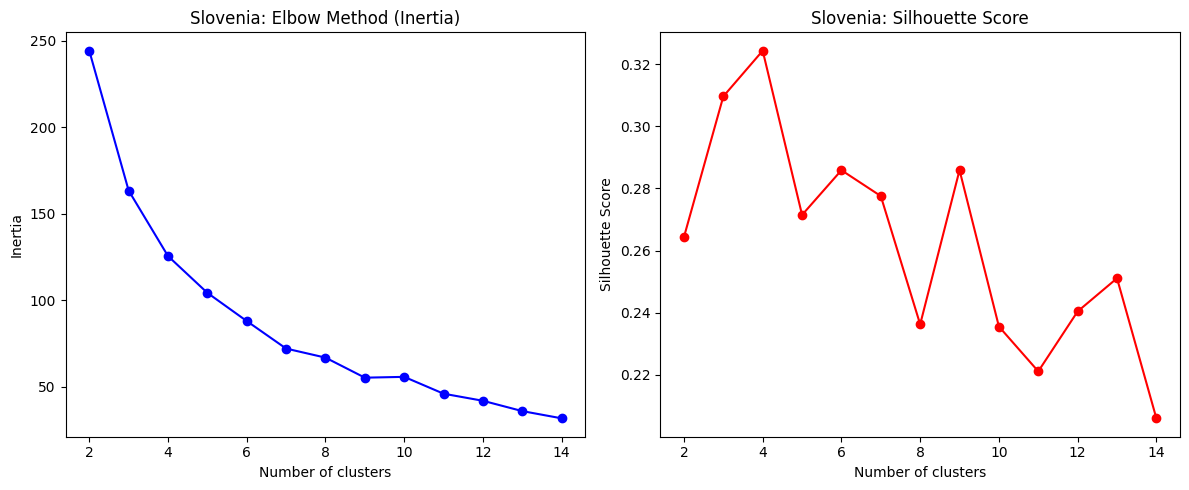

In [56]:
# plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# elbow plot
ax1.plot(K, inertia_sv, 'bo-')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Slovenia: Elbow Method (Inertia)')

# silhouette plot
ax2.plot(K, silh_sv, 'ro-')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Slovenia: Silhouette Score')

plt.tight_layout()
plt.show()

Based on the silhouette vs inertia scores for both Croatia and Slovenia, a good number of clusters is 3 because this is where the silhouette score is highest for each country and where there is a large drop in inertia. It isn't quite at the elbow yet, but we are informed to pick this because of the silhouette score.

In [57]:
# Fit to the decided number of clusters, concluded from inertia vs silh plots
kmeans_ct = KMeans(n_clusters = 3, random_state = 3799, n_init = 50).fit(croatia_dfscaled)
kmeans_sv = KMeans(n_clusters = 3, random_state = 3799, n_init = 50).fit(slovenia_dfscaled)

In [58]:
# get the cluster labels and assign them to the respected df
croatia_dfscaled['Cluster'] = kmeans_ct.labels_
slovenia_dfscaled['Cluster'] = kmeans_sv.labels_

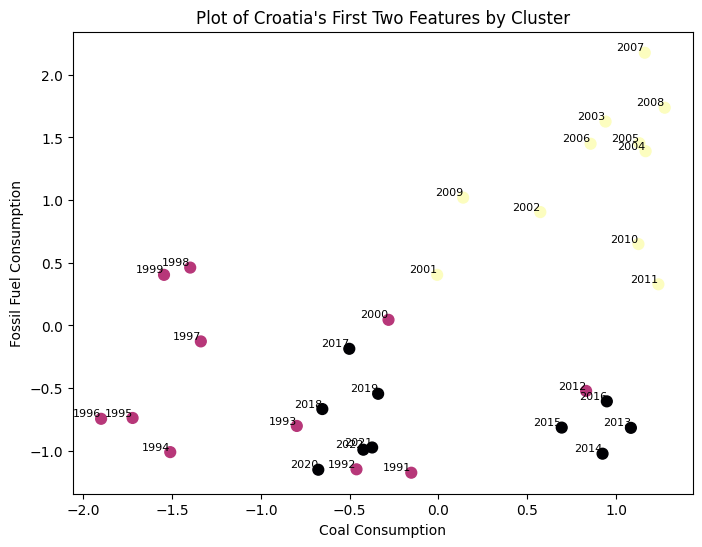

In [60]:
# CROATIA: plot the original two features with their cluster labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(croatia_dfscaled.iloc[:,0], croatia_dfscaled.iloc[:,1], cmap='magma', c=kmeans_ct.labels_, s=60)
plt.xlabel('Coal Consumption')
plt.ylabel('Fossil Fuel Consumption')
plt.title("Plot of Croatia's First Two Features by Cluster")
for i, year in enumerate(years_croatia):
    plt.text(croatia_dfscaled.iloc[i,0], croatia_dfscaled.iloc[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.show()

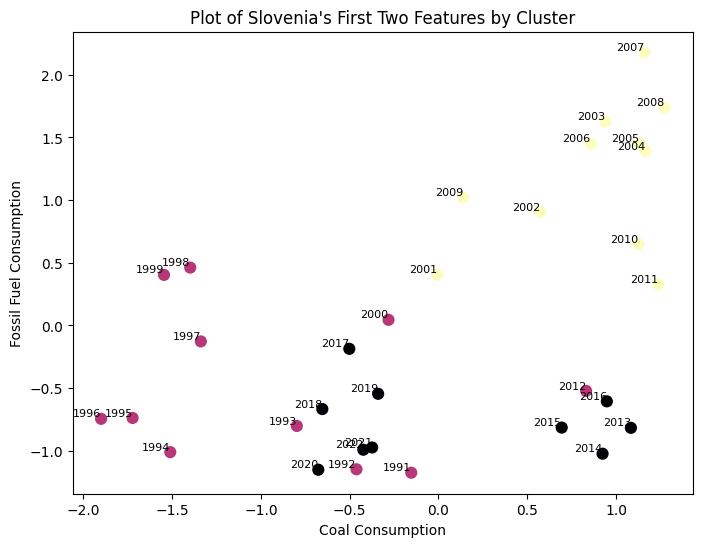

In [61]:
# SLOVENIA: plot the original two features with their cluster labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(slovenia_dfscaled.iloc[:,0], slovenia_dfscaled.iloc[:,1], cmap='magma', c=kmeans_sv.labels_, s=60)
plt.xlabel('Coal Consumption')
plt.ylabel('Fossil Fuel Consumption')
plt.title("Plot of Slovenia's First Two Features by Cluster")
for i, year in enumerate(years_slovenia):
    plt.text(slovenia_dfscaled.iloc[i,0], slovenia_dfscaled.iloc[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.show()

In [62]:
# fit on pca components
kmeans_pca_ct = KMeans(n_clusters = 3, random_state = 3799, n_init = 50).fit(X_pca_croatia)
kmeans_pca_sv = KMeans(n_clusters = 3, random_state = 3799, n_init = 50).fit(X_pca_slovenia)

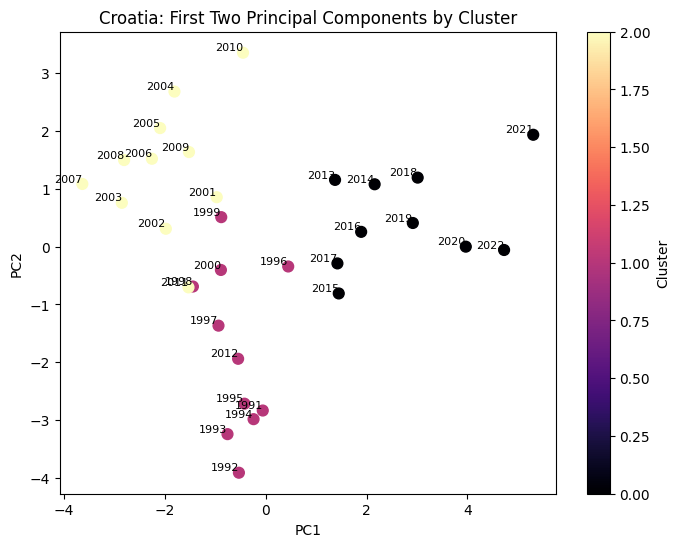

In [64]:
# CROATIA: plot the first two principal components with their cluster labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_croatia[:,0], X_pca_croatia[:,1], cmap='magma', c=kmeans_pca_ct.labels_, s=60)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Croatia: First Two Principal Components by Cluster")
for i, year in enumerate(years_croatia):
    plt.text(X_pca_croatia[i,0], X_pca_croatia[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.colorbar(scatter, label='Cluster')
plt.show()

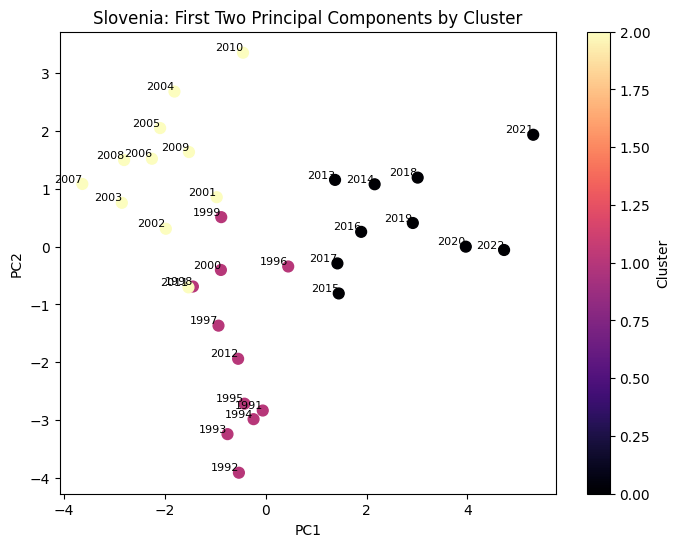

In [65]:
# SLOVENIA: plot the first two principal components with their cluster labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_slovenia[:,0], X_pca_slovenia[:,1], cmap='magma', c=kmeans_pca_sv.labels_, s=60)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Slovenia: First Two Principal Components by Cluster")
for i, year in enumerate(years_slovenia):
    plt.text(X_pca_slovenia[i,0], X_pca_slovenia[i,1], str(year), fontsize=8, ha='right', va='bottom')
plt.colorbar(scatter, label='Cluster')
plt.show()

For both the first two features and the first two principal components, there is clear clustering based on the years. So we will take a closer look into the structure of the features within these clusters for patterns.

In [66]:
# Look closer at the structure of Croatia's feature space 
for i in range(3):
    print(f"Cluster {i}:")
    print(croatia_dfscaled[croatia_dfscaled['Cluster'] == i].index.tolist())
    print(croatia_dfscaled[croatia_dfscaled['Cluster'] == i].mean())
    print()

Cluster 0:
[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
coal_consumption               0.067931
fossil_fuel_consumption       -0.777705
gas_consumption               -0.104250
hydro_consumption              0.054637
low_carbon_consumption         0.990476
nuclear_consumption            0.000000
oil_consumption               -0.960234
other_renewable_consumption    1.191499
primary_energy_consumption    -0.258403
renewables_consumption         0.990476
solar_consumption              1.260094
wind_consumption               1.324761
Cluster                        0.000000
dtype: float64

Cluster 1:
[1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2012]
coal_consumption              -0.934430
fossil_fuel_consumption       -0.487200
gas_consumption               -0.754846
hydro_consumption             -0.241338
low_carbon_consumption        -0.626577
nuclear_consumption            0.000000
oil_consumption               -0.065608
other_renewable_consumption   -0.5

### Evaluation of Croatia's Clustering Results

**Cluster 0**: 2013–2022
* High in: Low-carbon consumption, renewables, solar, wind, and other renewable consumption (all strongly positive scores).
* Low in: Fossil fuel, oil, and primary energy consumption.
* Coal and hydro: Around average (near zero).

These are recent years where Croatia has made a significant shift toward renewables (especially solar and wind) while reducing fossil fuel and oil consumption. This reflects a period of strong adoption of clean energy sources and decline in fossil fuel dependence.

**Cluster 1**: 1991–2000, 2012
* Low in: Coal, gas, hydro, low-carbon, other renewables, renewables, solar, wind, and primary energy.
* Near average: Oil (slightly negative), fossil fuels (moderately negative).
* Nuclear: Always zero (no nuclear for all years).

This group consists mostly of early years (the 1990s) and one transitional year (2012), characterized by lower overall energy use and particularly low renewable adoption. It likely reflects Croatia’s energy profile before significant changes toward renewables began.

**Cluster 2**: 2001–2011
* High in: Coal, fossil fuel, gas, oil, and primary energy consumption.
* Low in: Low-carbon, renewables, solar, wind, and other renewables (all negative).
* Hydro: Slightly above average.

These are the mid-years, where fossil fuel consumption (including coal, gas, and oil) was at its highest and renewables were not yet widely adopted. This period may represent an era of increased industrial activity and high energy demand before the transition to renewables.

## Heirarchical Clustering

In [68]:
### Data Cleaning
np.random.seed(3799)

croa_tf = croatia_dfscaled.transpose()
slov_tf = slovenia_dfscaled.transpose()

# Getting the energy types as the labels
croa_label = croa_tf.index
slov_label = slov_tf.index

# Initialize Hierarchical Clustering
HClust = AgglomerativeClustering

(array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125]),
 [Text(5, 0, 'Cluster'),
  Text(15, 0, 'primary_energy_consumption'),
  Text(25, 0, 'fossil_fuel_consumption'),
  Text(35, 0, 'oil_consumption'),
  Text(45, 0, 'nuclear_consumption'),
  Text(55, 0, 'coal_consumption'),
  Text(65, 0, 'gas_consumption'),
  Text(75, 0, 'other_renewable_consumption'),
  Text(85, 0, 'solar_consumption'),
  Text(95, 0, 'wind_consumption'),
  Text(105, 0, 'hydro_consumption'),
  Text(115, 0, 'low_carbon_consumption'),
  Text(125, 0, 'renewables_consumption')])

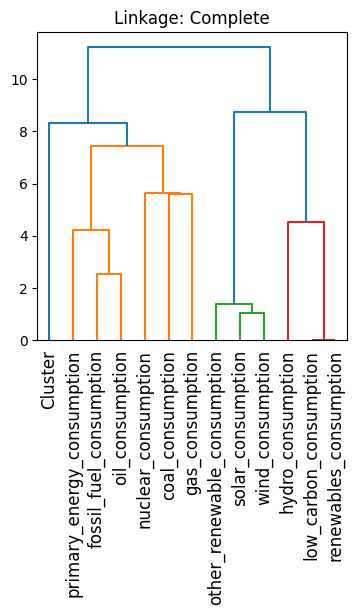

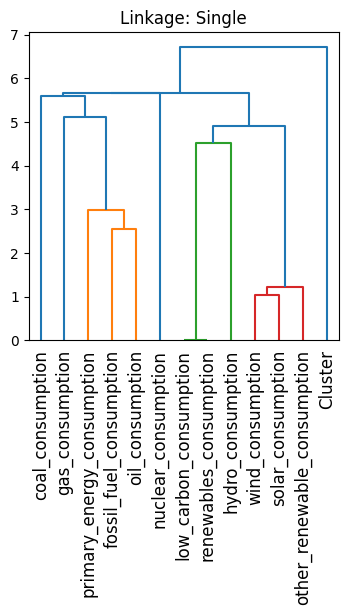

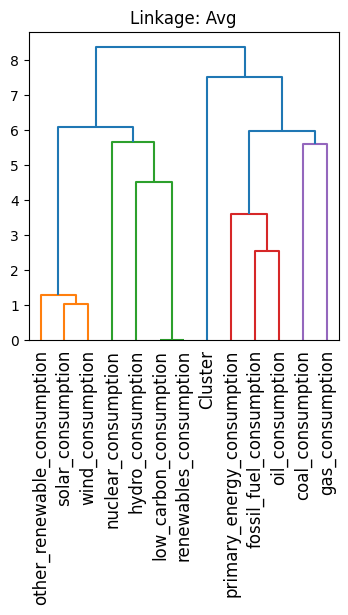

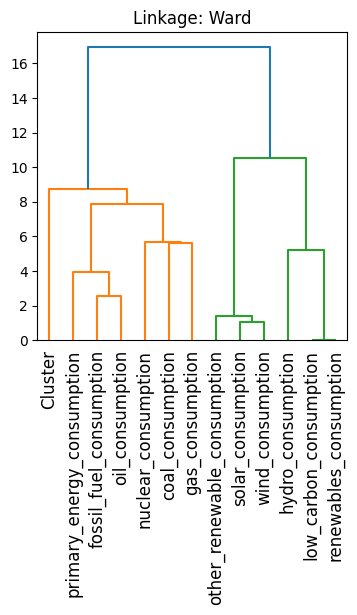

In [71]:
### Croatia Hierarchical CLustering
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
complete = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(croa_tf)
link_comp = compute_linkage(complete)
ax.set_title("Linkage: Complete");
_ = dendrogram(link_comp, ax = ax, labels = np.array(croa_label))
plt.xticks(rotation=90)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
single = HClust(distance_threshold = 0, n_clusters = None, linkage = 'single').fit(croa_tf)
link_comp = compute_linkage(single)
ax.set_title("Linkage: Single");
_ = dendrogram(link_comp, ax = ax, labels = np.array(croa_label))
plt.xticks(rotation=90)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
average = HClust(distance_threshold = 0, n_clusters = None, linkage = 'average').fit(croa_tf)
link_comp = compute_linkage(average)
ax.set_title("Linkage: Avg");
_ = dendrogram(link_comp, ax = ax, labels = np.array(croa_label))
plt.xticks(rotation=90)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ward = HClust(distance_threshold = 0, n_clusters = None, linkage = 'ward').fit(croa_tf)
link_comp = compute_linkage(ward)
ax.set_title("Linkage: Ward");
_ = dendrogram(link_comp, ax = ax, labels = np.array(croa_label))
plt.xticks(rotation=90)

(array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125]),
 [Text(5, 0, 'Cluster'),
  Text(15, 0, 'primary_energy_consumption'),
  Text(25, 0, 'fossil_fuel_consumption'),
  Text(35, 0, 'oil_consumption'),
  Text(45, 0, 'nuclear_consumption'),
  Text(55, 0, 'coal_consumption'),
  Text(65, 0, 'gas_consumption'),
  Text(75, 0, 'other_renewable_consumption'),
  Text(85, 0, 'solar_consumption'),
  Text(95, 0, 'wind_consumption'),
  Text(105, 0, 'hydro_consumption'),
  Text(115, 0, 'low_carbon_consumption'),
  Text(125, 0, 'renewables_consumption')])

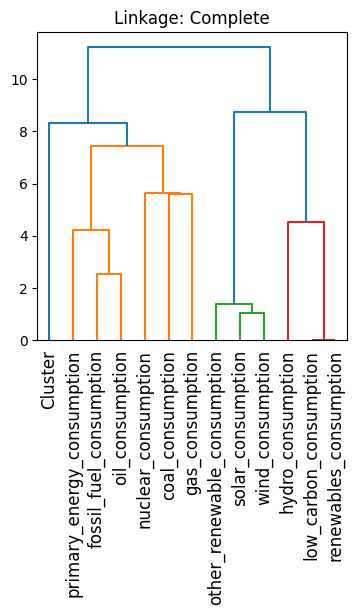

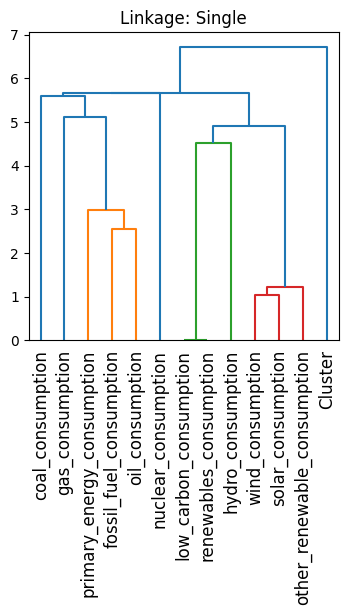

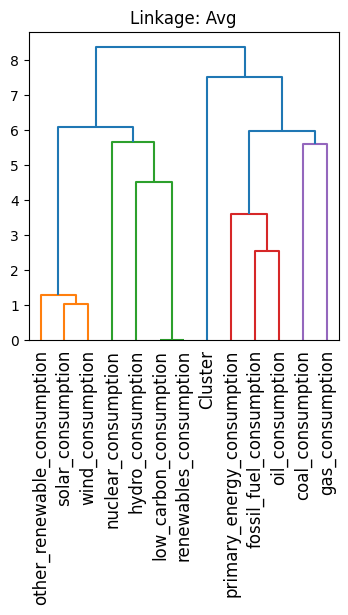

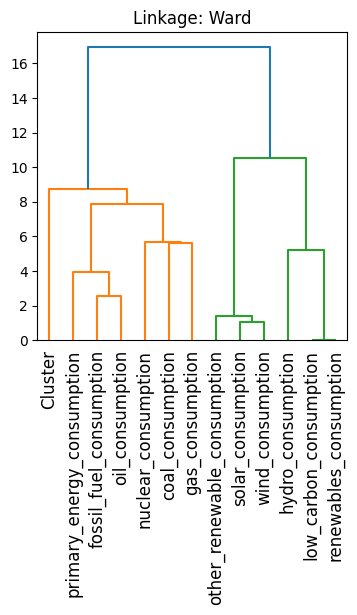

In [72]:
### Hierarchical Clustering: Slovenia
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
complete = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(slov_tf)
link_comp = compute_linkage(complete)
ax.set_title("Linkage: Complete");
_ = dendrogram(link_comp, ax = ax, labels = np.array(slov_label))
plt.xticks(rotation=90)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
single = HClust(distance_threshold = 0, n_clusters = None, linkage = 'single').fit(slov_tf)
link_comp = compute_linkage(single)
ax.set_title("Linkage: Single");
_ = dendrogram(link_comp, ax = ax, labels = np.array(slov_label))
plt.xticks(rotation=90)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
average = HClust(distance_threshold = 0, n_clusters = None, linkage = 'average').fit(slov_tf)
link_comp = compute_linkage(average)
ax.set_title("Linkage: Avg");
_ = dendrogram(link_comp, ax = ax, labels = np.array(slov_label))
plt.xticks(rotation=90)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ward = HClust(distance_threshold = 0, n_clusters = None, linkage = 'ward').fit(slov_tf)
link_comp = compute_linkage(ward)
ax.set_title("Linkage: Ward");
_ = dendrogram(link_comp, ax = ax, labels = np.array(slov_label))
plt.xticks(rotation=90)

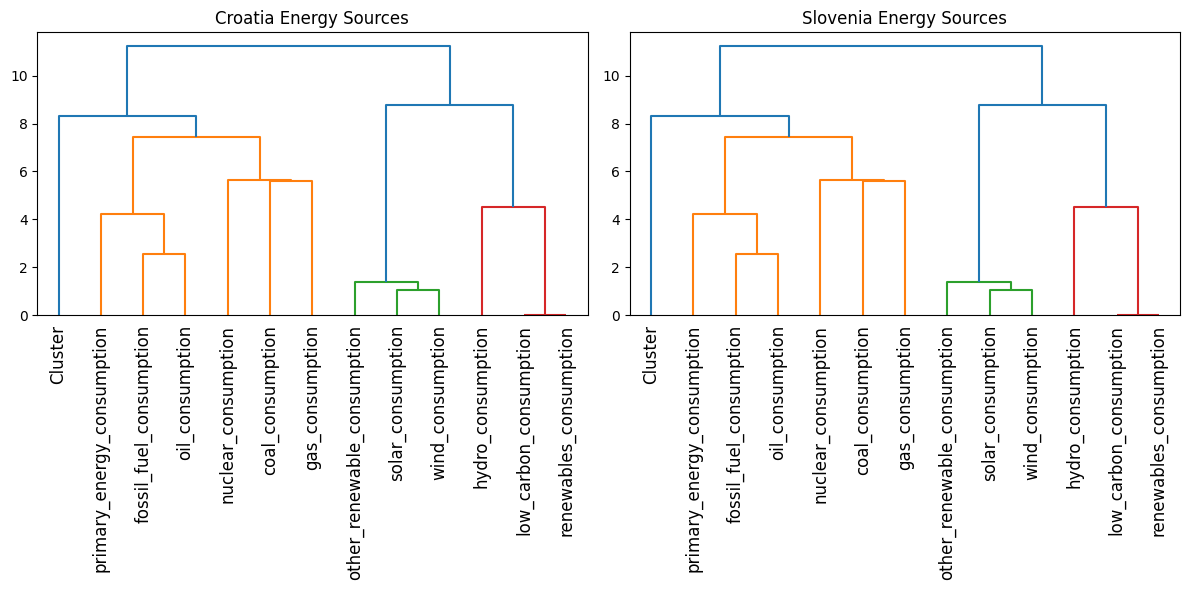

In [73]:
### Complete Linkage: Croatia vs Slovenia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
complete = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(croa_tf)
link_comp = compute_linkage(complete)
ax1.set_title("Croatia Energy Sources");
_ = dendrogram(
    link_comp, 
    ax = ax1, 
    labels = np.array(croa_label),)
ax1.tick_params(axis = 'x', rotation = 90)

complete = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(slov_tf)
link_comp = compute_linkage(complete)
ax2.set_title("Slovenia Energy Sources");
_ = dendrogram(link_comp, ax = ax2, labels = np.array(slov_label))
ax2.tick_params(axis = 'x', rotation = 90)

plt.tight_layout()
plt.show()

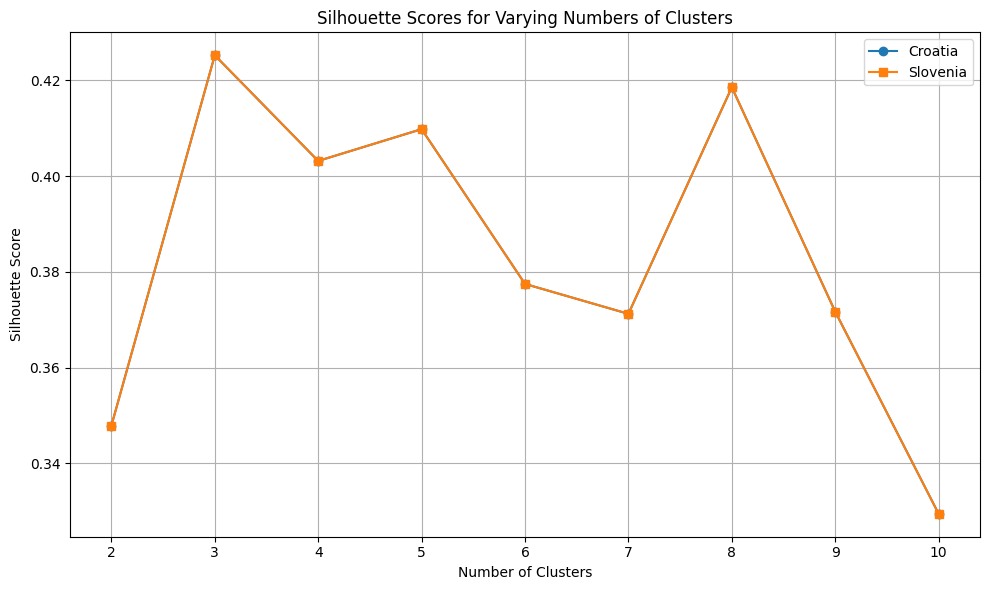

In [76]:
def evaluate_clusters_silhouette(data, link, max = 10):
    silhouette_scores = []
    cluster_range = range(2, max + 1) 
    
    for n_clusters in cluster_range:
        cluster_labels = fcluster(link, n_clusters, criterion = 'maxclust')
        score = silhouette_score(data, cluster_labels)
        silhouette_scores.append(score)
    return cluster_range, silhouette_scores

# Croatian data
complete_croa = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(croa_tf)
link_comp_croa = compute_linkage(complete_croa)
croa_range, croa_scores = evaluate_clusters_silhouette(croa_tf, link_comp_croa)

# Slovenian data
complete_slov = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(slov_tf)
link_comp_slov = compute_linkage(complete_slov)
slov_range, slov_scores = evaluate_clusters_silhouette(slov_tf, link_comp_slov)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(croa_range, croa_scores, 'o-', label = 'Croatia')
plt.plot(slov_range, slov_scores, 's-', label = 'Slovenia')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Varying Numbers of Clusters')
plt.legend()
plt.grid(True)
plt.xticks(list(croa_range))
plt.tight_layout()
plt.show()

## Results

### PCA
The first 5 prinicpal components pretty much capture most of the variance for both Croatia and Slovania. The first principal component captures almost half of the variance in the data, about 46% for both countries. After 5 principal components, most of the varaince is explained in the data as the graph approaches 1.0. This indicates that the dimensionality of the data can effective be recued from 12 to 5 principal components without significant loss of the datas varaince. 

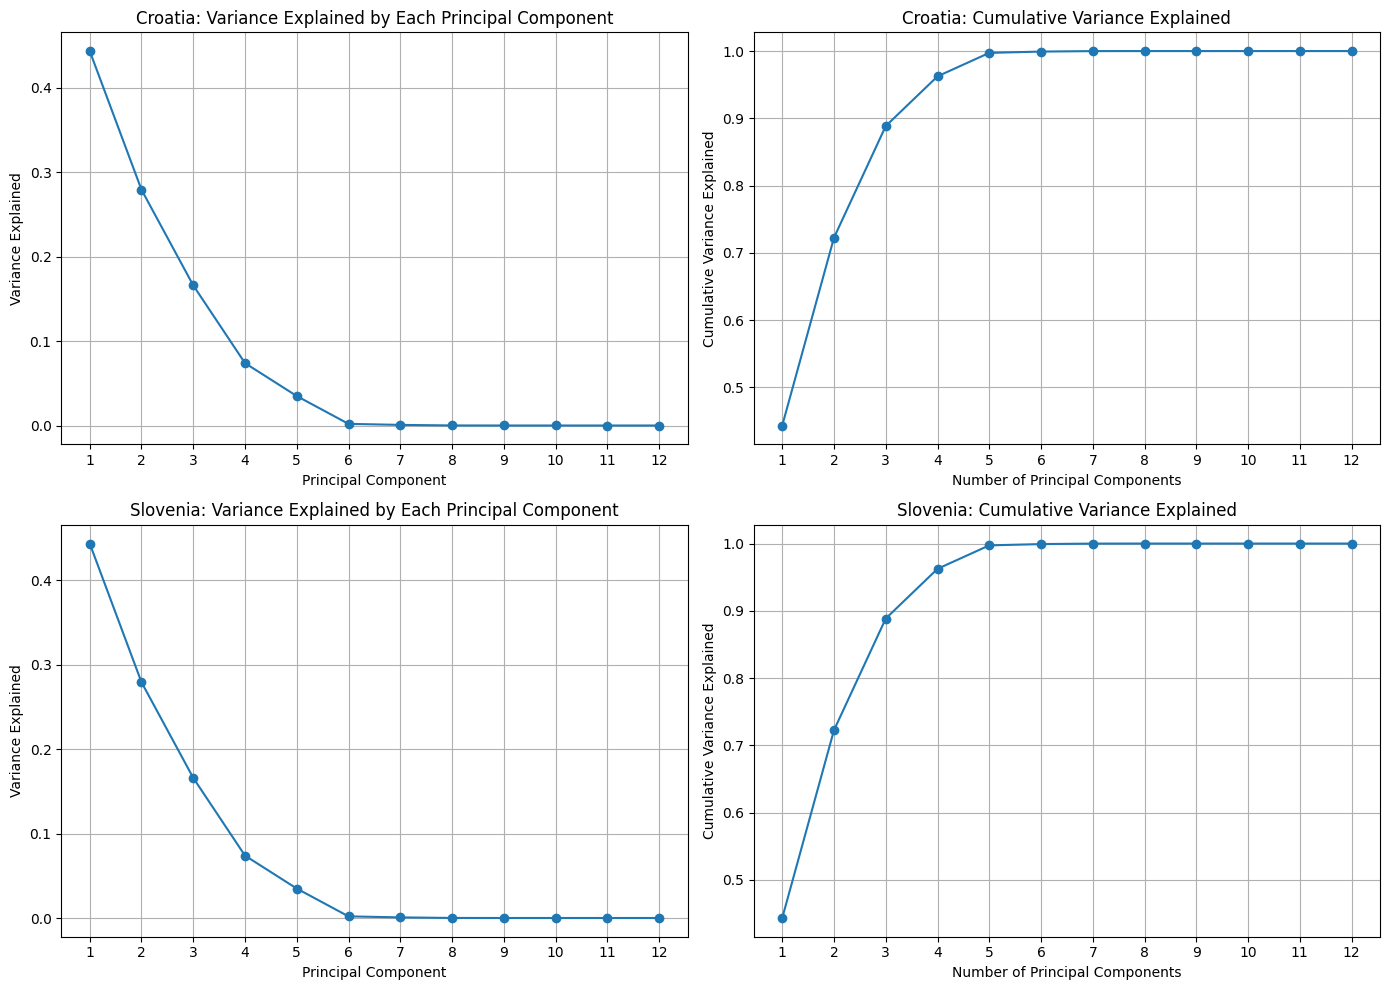

In [90]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Croatia: Variance Explained
axes[0, 0].plot(range(1, 13), explained_var_croatia, 'o-')
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Variance Explained')
axes[0, 0].set_title('Croatia: Variance Explained by Each Principal Component')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].grid(True)

# Croatia: Cumulative Variance Explained 
axes[0, 1].plot(range(1, 13), cum_explained_var_croatia, 'o-')
axes[0, 1].set_xlabel('Number of Principal Components')
axes[0, 1].set_ylabel('Cumulative Variance Explained')
axes[0, 1].set_title('Croatia: Cumulative Variance Explained')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].grid(True)

# Slovenia: Variance Explained 
axes[1, 0].plot(range(1, 13), explained_var_slovenia, 'o-')
axes[1, 0].set_xlabel('Principal Component')
axes[1, 0].set_ylabel('Variance Explained')
axes[1, 0].set_title('Slovenia: Variance Explained by Each Principal Component')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(True)

# Slovenia: Cumulative Variance Explained
axes[1, 1].plot(range(1, 13), cum_explained_var_slovenia, 'o-')
axes[1, 1].set_xlabel('Number of Principal Components')
axes[1, 1].set_ylabel('Cumulative Variance Explained')
axes[1, 1].set_title('Slovenia: Cumulative Variance Explained')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


The first principal component represents a clear difference between renewable/low-carbon energy sources and fossil fuel consumption. Years with higher wind, solar, and other renewable energy use score highly on this component, while years with greater fossil fuel (especially oil and gas) consumption score lower. Principal component 1 reflects a transition from fossil fuel consumption to renewable energy consumption. By plotting PC1 and PC2 and coloring the points by year, we can see a progression that earlier years have low PC1 values and later years have high PC1 values. This reinforcned the interpretation that Croatia and Slovenia have both shifted towards renewable energy sourcers overtime. Plotting Slovenia's first two features, coal and fossil fuel comsumption, there is a visible trend that shows early years have low fossil fuel use, middle years fluctuate, and recent years show declining coal use and low fossil fuel use. 

### SVD
Each row of **U** can be interpreted as one observation (in our case, each year) that has 12 scores, each one representing the principal component it is associated with (e.g., the first index in the row represents the first principal component). All these observations indicate how each load onto each principal component. For example, taking the first column of U (PC1), it shows us how all the years are being loaded/projected onto the first principal component.

Each row of **Vt** can be interpreted as how each feature is weighted on each principal component. So the larger the value (in magnitude), the more that feature influences the corresponding principal component, and positive and negative values show whether the feature contributes in the same direction as the component or in the opposite direction. Therefore, if one looks at the first row of Vt, it can be seen which features are most responsible for the variation captured by the first principal component.

#### KMeans Clustering

For both countries, k = 3 yields the high silhouette scores and a noticeable drop in within cluster variation. A good number of clusters is 3 because this is where the silhouette score is highest for each country and where there is a large drop in inertia. It isn't quite at the elbow yet, but we are informed to pick this because of the silhouette score.

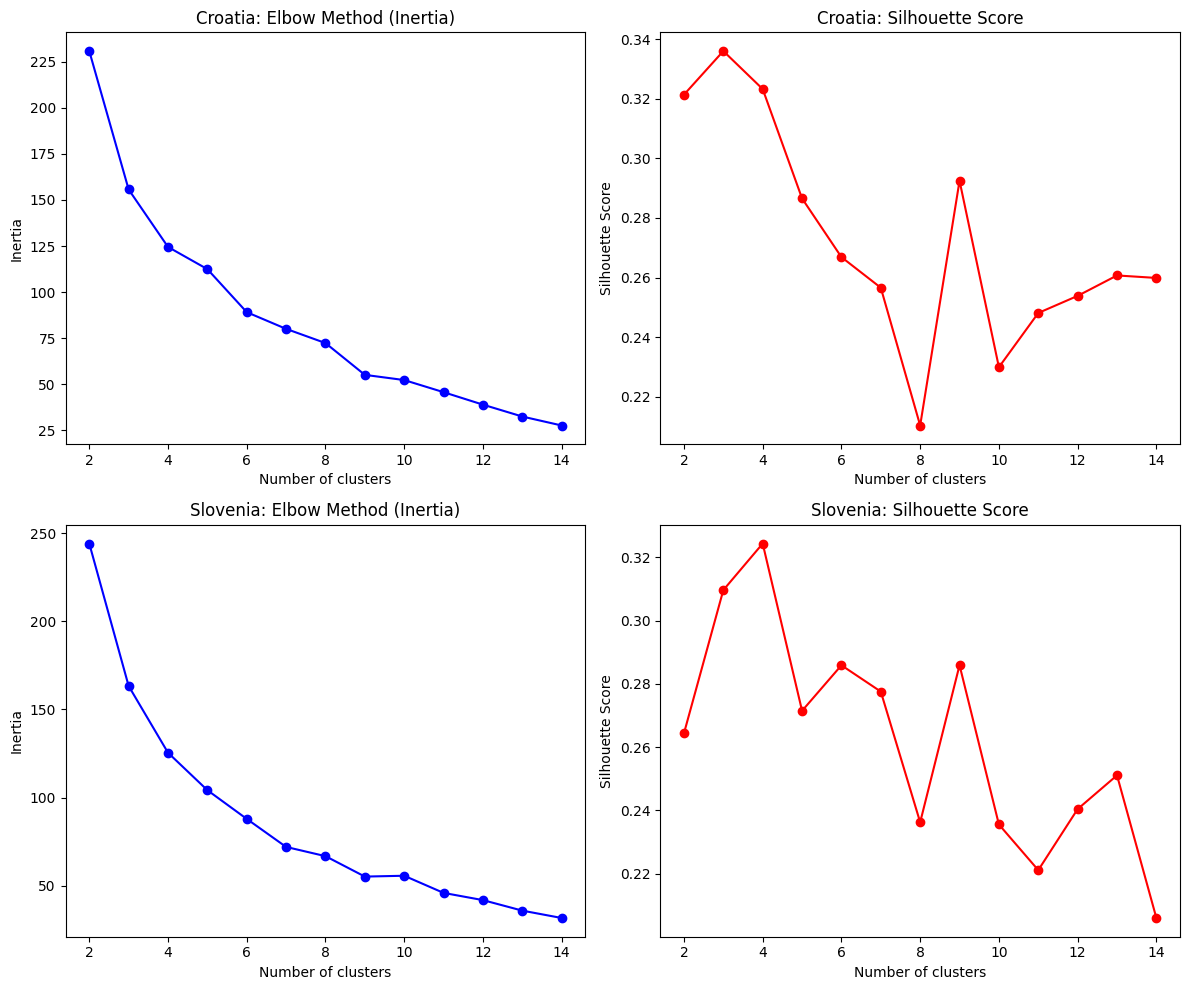

In [88]:
K = range(2, 15)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

### Croatia
# Elbow
axes[0, 0].plot(K, inertia_ct, 'bo-')
axes[0, 0].set_xlabel('Number of clusters')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Croatia: Elbow Method (Inertia)')

# Silhouette
axes[0, 1].plot(K, silh_ct, 'ro-')
axes[0, 1].set_xlabel('Number of clusters')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Croatia: Silhouette Score')

### Slovenia
# Elbow
axes[1, 0].plot(K, inertia_sv, 'bo-')
axes[1, 0].set_xlabel('Number of clusters')
axes[1, 0].set_ylabel('Inertia')
axes[1, 0].set_title('Slovenia: Elbow Method (Inertia)')

# Silhouette
axes[1, 1].plot(K, silh_sv, 'ro-')
axes[1, 1].set_xlabel('Number of clusters')
axes[1, 1].set_ylabel('Silhouette Score')
axes[1, 1].set_title('Slovenia: Silhouette Score')

plt.tight_layout()
plt.show()


**Cluster 0**: 2013–2022
* High in: Low-carbon consumption, renewables, solar, wind, and other renewable consumption (all strongly positive scores).
* Low in: Fossil fuel, oil, and primary energy consumption.
* Coal and hydro: Around average (near zero).

These are recent years where Croatia has made a significant shift toward renewables (especially solar and wind) while reducing fossil fuel and oil consumption. This reflects a period of strong adoption of clean energy sources and decline in fossil fuel dependence.

**Cluster 1**: 1991–2000, 2012
* Low in: Coal, gas, hydro, low-carbon, other renewables, renewables, solar, wind, and primary energy.
* Near average: Oil (slightly negative), fossil fuels (moderately negative).
* Nuclear: Always zero (no nuclear for all years).

This group consists mostly of early years (the 1990s) and one transitional year (2012), characterized by lower overall energy use and particularly low renewable adoption. It likely reflects Croatia’s energy profile before significant changes toward renewables began.

**Cluster 2**: 2001–2011
* High in: Coal, fossil fuel, gas, oil, and primary energy consumption.
* Low in: Low-carbon, renewables, solar, wind, and other renewables (all negative).
* Hydro: Slightly above average.

These are the mid-years, where fossil fuel consumption (including coal, gas, and oil) was at its highest and renewables were not yet widely adopted. This period may represent an era of increased industrial activity and high energy demand before the transition to renewables.

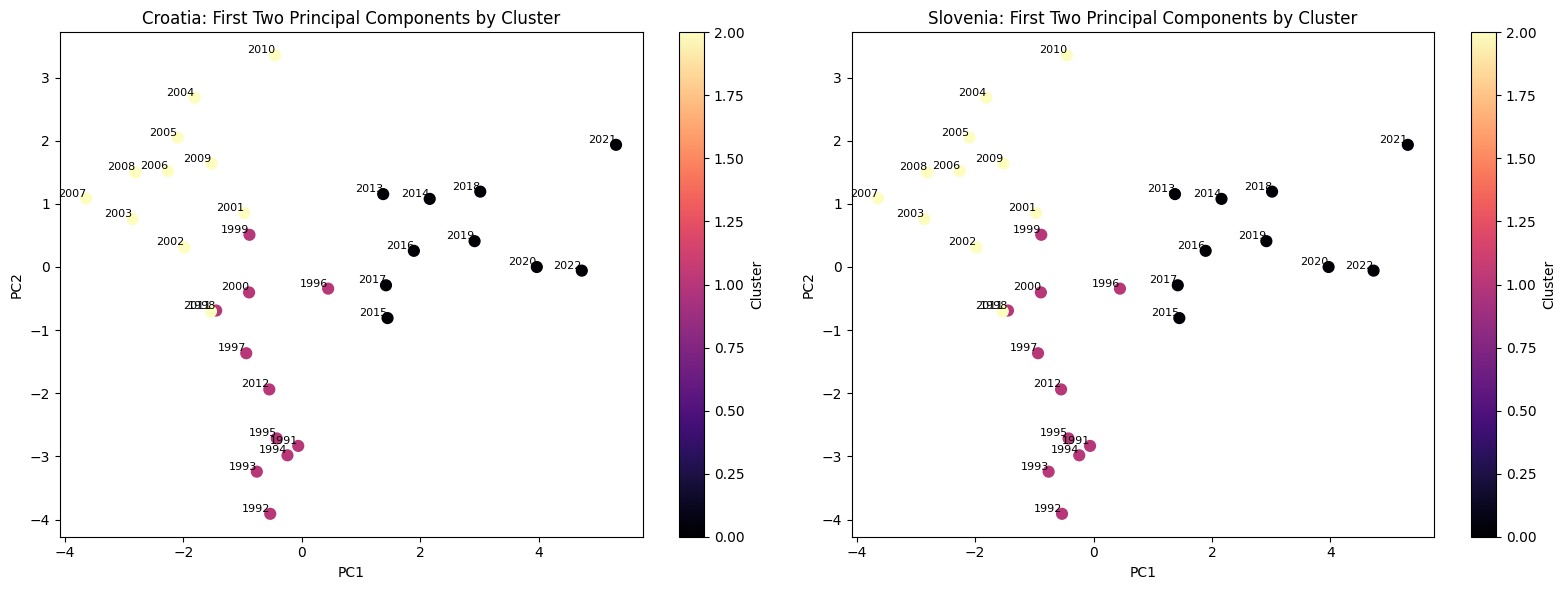

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

### CROATIA
scatter1 = axes[0].scatter(X_pca_croatia[:, 0], X_pca_croatia[:, 1],
                           c=kmeans_pca_ct.labels_, cmap='magma', s=60)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title("Croatia: First Two Principal Components by Cluster")
for i, year in enumerate(years_croatia):
    axes[0].text(X_pca_croatia[i, 0], X_pca_croatia[i, 1], str(year),
                 fontsize=8, ha='right', va='bottom')
cbar1 = fig.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster')

### SLOVENIA
scatter2 = axes[1].scatter(X_pca_slovenia[:, 0], X_pca_slovenia[:, 1],
                           c=kmeans_pca_sv.labels_, cmap='magma', s=60)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title("Slovenia: First Two Principal Components by Cluster")
for i, year in enumerate(years_slovenia):
    axes[1].text(X_pca_slovenia[i, 0], X_pca_slovenia[i, 1], str(year),
                 fontsize=8, ha='right', va='bottom')
cbar2 = fig.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Cluster')

plt.tight_layout()
plt.show()


Overall, KMeans clustering sucessfully segmented the country's energy timeline into 3 periods which includes: pre-transition, transition peak of fossil fuel, and pos-transition towards renewables. This allows us to see trends in the data that might not have need as clear before.

#### Hierarchical Clustering

Both countries resulted in structuarlly similar dendrograms, with slight differences in distances between the clustering groups. Complete linkage shows the most balanced and compact structure, grouping similar types of energy together like fuel and oil or carbon and renewables, likely reflecting similar usage patterns within the country. Single linkage shows a very unbalanced dendrogram, and does not do a good job seperating the clusters. Average linkage looks like somewhat of a balance between complete and single, grouping some similar energy types together. Finally the ward cluster shows a pretty clear grouping between renewable energy and fuels. 

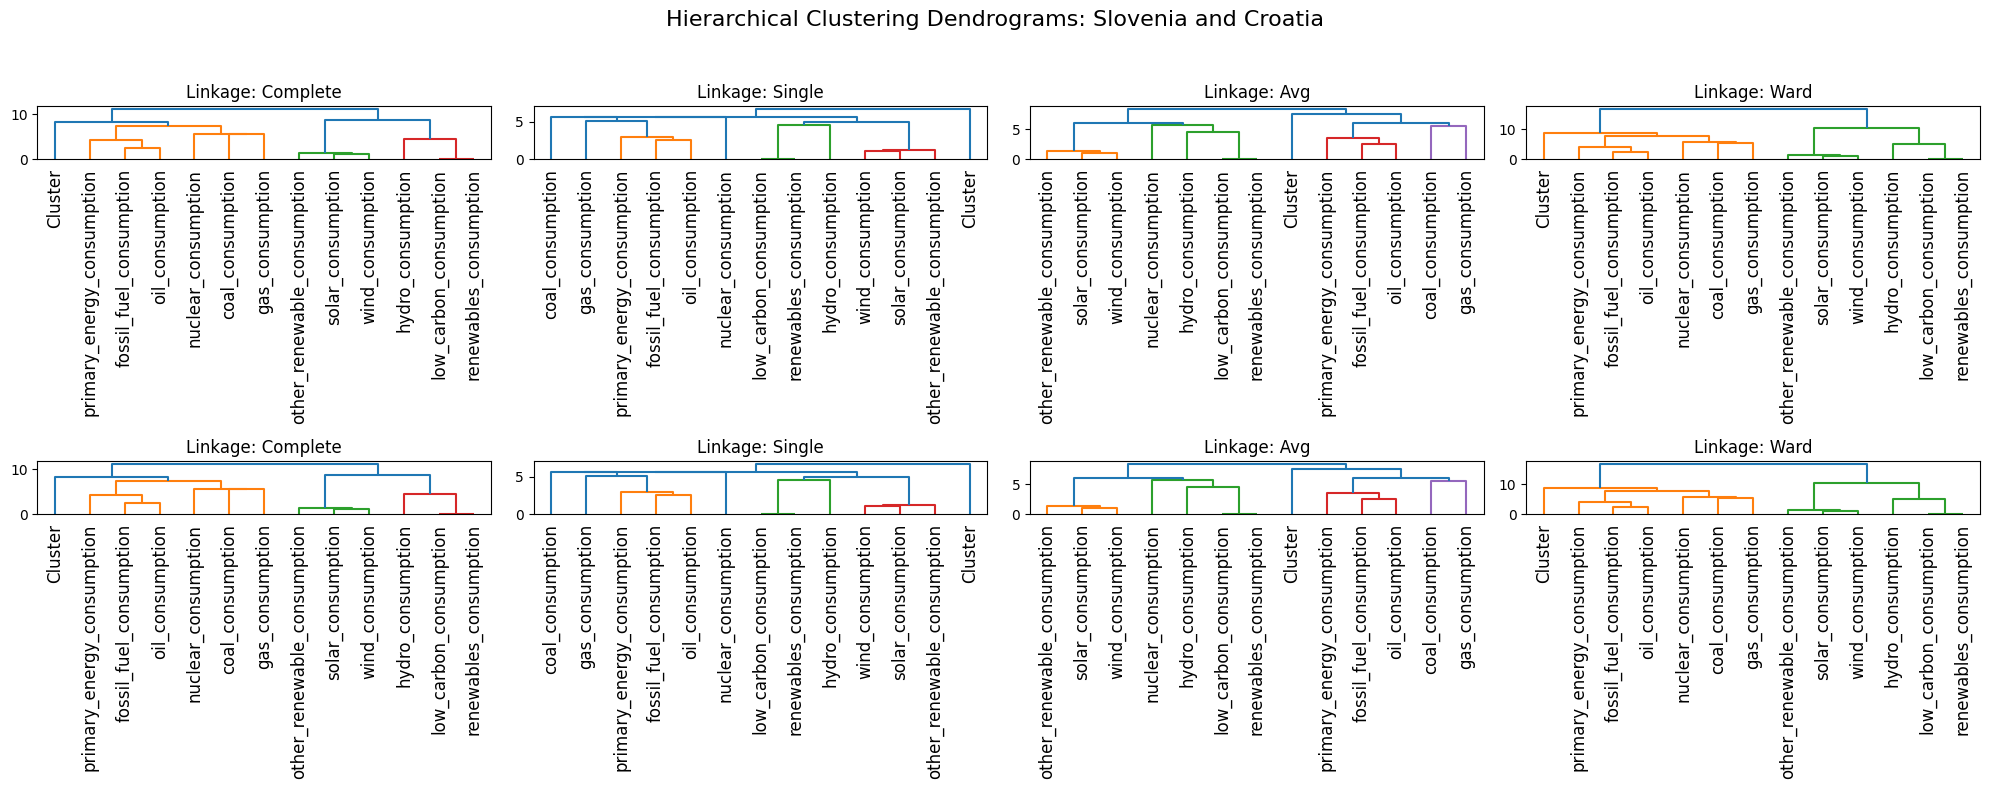

In [84]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))  # 2 rows, 4 columns

# Slovenia dendrograms
linkages = ['complete', 'single', 'average', 'ward']
titles = ['Linkage: Complete', 'Linkage: Single', 'Linkage: Avg', 'Linkage: Ward']

for i, method in enumerate(linkages):
    model = HClust(distance_threshold=0, n_clusters=None, linkage=method).fit(slov_tf)
    link = compute_linkage(model)
    axes[0, i].set_title(titles[i])
    dendrogram(link, ax=axes[0, i], labels=np.array(slov_label))
    axes[0, i].tick_params(axis='x', rotation=90)

# Croatia dendrograms
for i, method in enumerate(linkages):
    model = HClust(distance_threshold=0, n_clusters=None, linkage=method).fit(croa_tf)
    link = compute_linkage(model)
    axes[1, i].set_title(titles[i])
    dendrogram(link, ax=axes[1, i], labels=np.array(croa_label))
    axes[1, i].tick_params(axis='x', rotation=90)

# General layout tweaks
plt.suptitle("Hierarchical Clustering Dendrograms: Slovenia and Croatia", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


Comparing the complete linkage dendrogram for both countries, their energy consumption looks almost identical. The fossil fuels are clustered tightly together, and the renewable energy clearly forms a seperate cluster. 

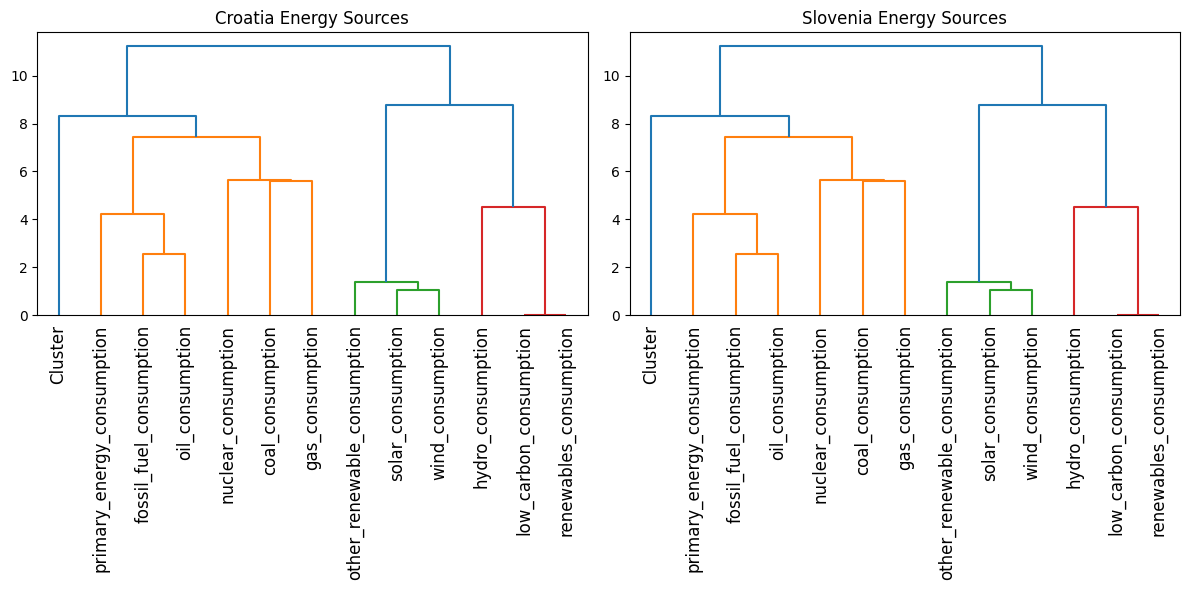

In [85]:
### Complete Linkage: Croatia vs Slovenia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
complete = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(croa_tf)
link_comp = compute_linkage(complete)
ax1.set_title("Croatia Energy Sources");
_ = dendrogram(
    link_comp, 
    ax = ax1, 
    labels = np.array(croa_label),)
ax1.tick_params(axis = 'x', rotation = 90)

complete = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(slov_tf)
link_comp = compute_linkage(complete)
ax2.set_title("Slovenia Energy Sources");
_ = dendrogram(link_comp, ax = ax2, labels = np.array(slov_label))
ax2.tick_params(axis = 'x', rotation = 90)

plt.tight_layout()
plt.show()

The Silhoutette score helps select the optimal number of clusters, the best number being about 2-3 meaningful clusters for both countries. These groupings likely refer to the separation between foil fuels and renewable energy. Slovenia has a higher silhouette score overall, maybe indicating that they have better defined clusters than Croatia due to more distinct energy usage patters.

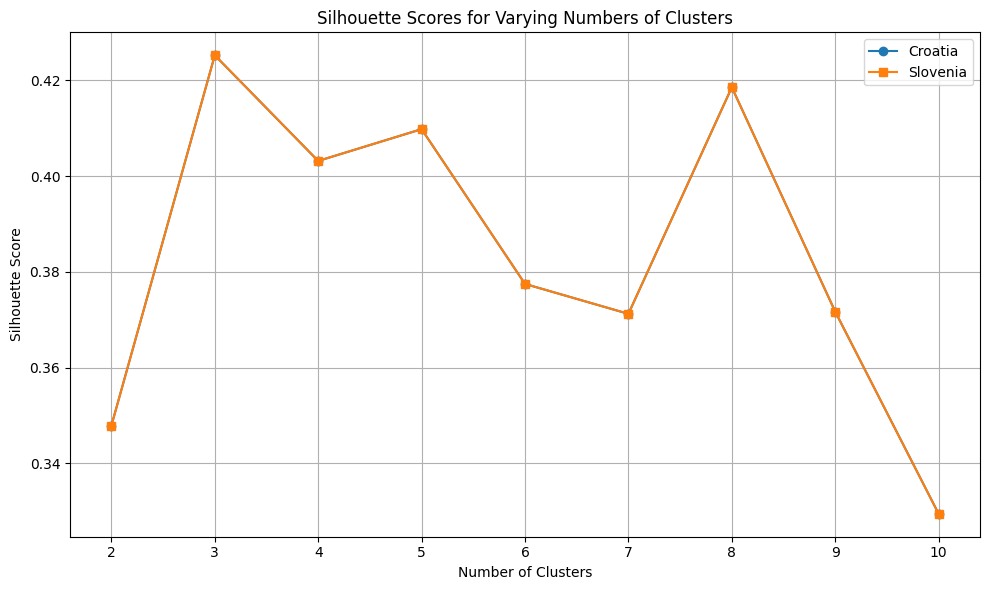

In [86]:
def evaluate_clusters_silhouette(data, link, max = 10):
    silhouette_scores = []
    cluster_range = range(2, max + 1) 
    
    for n_clusters in cluster_range:
        cluster_labels = fcluster(link, n_clusters, criterion = 'maxclust')
        score = silhouette_score(data, cluster_labels)
        silhouette_scores.append(score)
    return cluster_range, silhouette_scores

# Croatian data
complete_croa = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(croa_tf)
link_comp_croa = compute_linkage(complete_croa)
croa_range, croa_scores = evaluate_clusters_silhouette(croa_tf, link_comp_croa)

# Slovenian data
complete_slov = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(slov_tf)
link_comp_slov = compute_linkage(complete_slov)
slov_range, slov_scores = evaluate_clusters_silhouette(slov_tf, link_comp_slov)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(croa_range, croa_scores, 'o-', label = 'Croatia')
plt.plot(slov_range, slov_scores, 's-', label = 'Slovenia')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Varying Numbers of Clusters')
plt.legend()
plt.grid(True)
plt.xticks(list(croa_range))
plt.tight_layout()
plt.show()

## Discussion

PCA effectively reduced the dimensionality of the datasets while preserving the core structure of the data, hence was able to provide insightful trends and patterns from Croatia and Slovania's energy profile. The dominant trend in both Croatia and Slovenia is a shift in energy consumption patterns, moving from fossil fuels toward renewables over the years. The dimensionality reduction shows that a small number of components (mainly PC1) account for most of the variance, making PCA a valuable tool for visualizing and understanding long-term trends in energy data.

The KMeans model effectively grouped the years into 3 clusters, with similar trends occuring in both Croatia and Slovania. The main trend seen among KMeans clustering is the transition from fossil fuels to renewable energy. The most recent years (2013-2022) show a significant shift towards renewable energy, pariculatlry solar and wind energy. The middle years (2001-2011) show high fossily fuel consumptions, indicating high industrial activity and energy demands during a time when renewable energy was not widely adopted. Lastly the early years (1991-2001) shows over all low energy consumption, with some fossil fuel usage and basically no renewable energy implementations yet. The KMeans model validates and gives mroe insights into our PCA findings, describing the major types of energy usage throughout the years.

Finally, the dendrogram provides a visual representation of the types of energy usage in both Croatia and Slovania. Comparing a hierarchical clustering using complete linkage, their dendrograms look almost identical, indicating that both countries utilize fossil fuels and renewable energy relatively similarly. Again, enforcing our findings from previous unsupervised learning techniques it is clear there is a cluster which represents fossil fuels and one that represents renewable energy. Fossil fuels seem to be groupd in a strong cluster, meaning they are clearly similar in their usage for both countries and an established energy type. The renewable energys are more newly developed and form into their custer more gradually. 

## Conclusion

This study demonstrates the power of unsupervised learning techniques like PCA, KMeans clustering, and hierarchical clustering, in uncovering meaningful patterns within energy consumption data for Croatia and Slovenia. Despite the datasets originating from different countries, the trends revealed were remarkably similar, suggesting a shared trajectory in their energy transitions over the past three decades. Mainly, highlighting the dominant shift from fossil fuel reliance to renewable energy adoption. 

Identifying long term trends in countries using energy profiles reflects broader global energy transition patterns, which can be used to support ongoing polocy changes and enviornemntal efforts. Understanding this newfound shift towards renewable energy can help inform goverments, researchers, and energy providers to better understand historical patterns and make data driven investments about future decisions. This study shows how unsupervised learning technaiques can go beyond simple predictions tasks, to inform strategic decisions about energy, the enviornment, and sustainability.  